In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from sklearn.inspection import permutation_importance
from scipy.special import boxcox1p
from func import get_goals_proba, get_goal_line_proba, get_win_proba

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.get_option("display.max_columns")
pd.set_option("display.max_columns", None)

In [3]:
df = pd.read_csv('data.csv',index_col=0)
slice_t = 1672531200
df_model = df.loc[df['match_start']<slice_t].fillna(0)
df_pred = df.loc[df['match_start']>=slice_t].fillna(0)

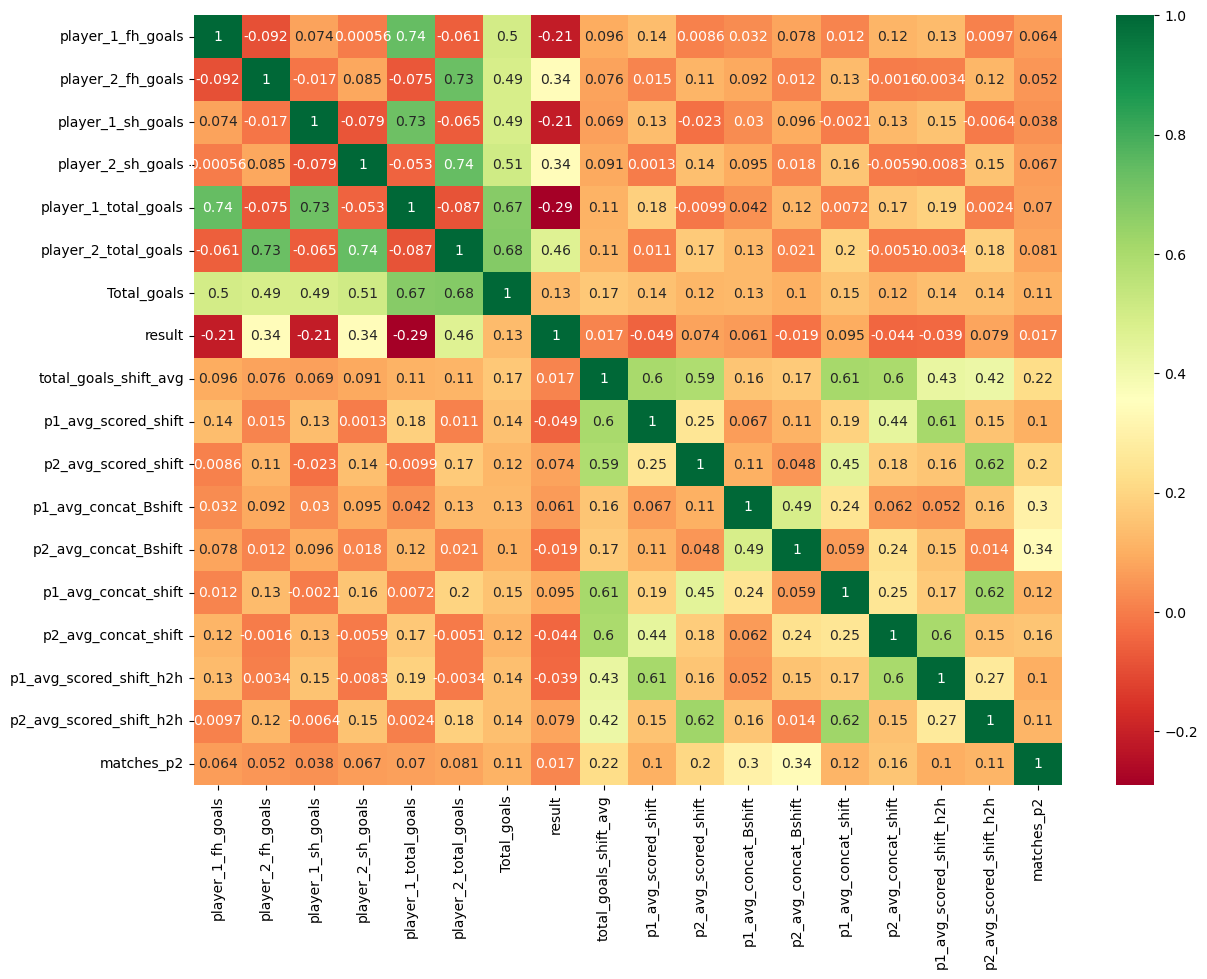

In [4]:
corrmat = df_model.corr()
top_corr_features = corrmat.index[abs(corrmat["Total_goals"])>0.1]
plt.figure(figsize=(14,10))
g = sns.heatmap(df_model[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [5]:
cols_to_drop = ['player_1_p2','Total_goals', 'result', 'p1_bilance', 'p2_bilance','wins_h2h_p2','wins_h2h','wins_p2','matches_p2','matches','wins','matchesh2h_p2','matches_shift_p2','matchesh2h','matches_shift' ]
df_model_1 = df_model.drop(cols_to_drop,axis=1).copy()
df_pred_1 = df_pred.drop(cols_to_drop,axis=1).copy()

In [6]:
df_model_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7840 entries, 0 to 7839
Data columns (total 39 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   match_id                              7840 non-null   int64  
 1   date_planned_start                    7840 non-null   int64  
 2   match_start                           7840 non-null   int64  
 3   player_1                              7840 non-null   int64  
 4   player_2                              7840 non-null   int64  
 5   player_1_fh_goals                     7840 non-null   int64  
 6   player_2_fh_goals                     7840 non-null   int64  
 7   player_1_sh_goals                     7840 non-null   int64  
 8   player_2_sh_goals                     7840 non-null   int64  
 9   player_1_total_goals                  7840 non-null   int64  
 10  player_2_total_goals                  7840 non-null   int64  
 11  shift_n          

In [7]:
df_model_1['h2h_momentum_p2'] = df_model_1['h2h_momentum']*-1
df_pred_1['h2h_momentum_p2'] = df_pred['h2h_momentum']*-1

## Model

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

cols_to_model = ['cumulative_p1_shift','cumulative_p2_shift','cumulative_h2h_shift','total_goals_shift_avg','p1_avg_scored_Bshift','p1_avg_scored_shift','p1_avg_scored_shift_h2h','p1_avg_scored_Bshift_h2h','p1_momentum_s_total','p2_momentum_s_total','h2h_momentum','h2h_momentum_p2','p1_goals_momentum_s','win_rate','win_rate_p2','win_rate_h2h','matchesh2h']
# df_model_1 = df_model_1[(df_model_1['player_1_total_goals'] <7) & (df_model_1['player_2_total_goals'] <7)]
X = df_model_1.iloc[:, 14:]
scaler = StandardScaler()

y = df_model_1.iloc[:, [9,10]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [9]:
import numpy as np
import tensorflow as tf


# Vytvoření modelu neuronové sítě s BatchNormalization
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.BatchNormalization(),   
    tf.keras.layers.Dropout(0.32),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(2, activation='exponential')
])

# Kompilace modelu s Poissonovým rozdělením
model.compile(optimizer='adam', loss='poisson')

# Trénování modelu
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Predikce na testovacích datech
y_pred = np.round(model.predict(X_test)).astype(int)


Epoch 1/50
172/172 [==============================] - 1s 3ms/step - loss: 1.1010 - val_loss: 0.7352
Epoch 2/50
172/172 [==============================] - 0s 2ms/step - loss: 0.6417 - val_loss: 0.5147
Epoch 3/50
172/172 [==============================] - 0s 2ms/step - loss: 0.5347 - val_loss: 0.4835
Epoch 4/50
172/172 [==============================] - 0s 2ms/step - loss: 0.5115 - val_loss: 0.4725
Epoch 5/50
172/172 [==============================] - 0s 2ms/step - loss: 0.4945 - val_loss: 0.4613
Epoch 6/50
172/172 [==============================] - 0s 2ms/step - loss: 0.4851 - val_loss: 0.4646
Epoch 7/50
172/172 [==============================] - 0s 2ms/step - loss: 0.4820 - val_loss: 0.4554
Epoch 8/50
172/172 [==============================] - 0s 2ms/step - loss: 0.4739 - val_loss: 0.4555
Epoch 9/50
172/172 [==============================] - 0s 2ms/step - loss: 0.4750 - val_loss: 0.4499
Epoch 10/50
172/172 [==============================] - 0s 2ms/step - loss: 0.4718 - val_loss: 0.4475

 ##  features importance

In [10]:
import eli5
from eli5.sklearn import PermutationImportance

# Vytvoření instance modelu pro Permutation Importance
perm = PermutationImportance(model, random_state=1,scoring='neg_mean_absolute_error')

# Naučení Permutation Importance na trénovacích datech
perm.fit(X_train, y_train)

# Vypsání důležitostí příznaků


172/172 [==============================] - 0s 731us/step


PermutationImportance(estimator=<keras.engine.sequential.Sequential object at 0x000001BA2303A8E0>,
                      random_state=1, scoring='neg_mean_absolute_error')

In [11]:
eli5.show_weights(perm, feature_names=X.columns.tolist())

Weight,Feature
0.0077 ± 0.0017,win_rate_h2h
0.0069 ± 0.0004,p1_avg_concat_Bshift
0.0066 ± 0.0014,p1_avg_scored_shift_h2h
0.0055 ± 0.0012,p2_avg_scored_shift
0.0051 ± 0.0008,p2_avg_scored_Bshift_h2h
0.0049 ± 0.0011,win_rate
0.0048 ± 0.0022,win_rate_h2h_p2
0.0042 ± 0.0020,p2_avg_concat_Bshift
0.0035 ± 0.0003,bilance_h2h_shift
0.0033 ± 0.0008,win_rate_p2


 ##  prediction

In [12]:
val = scaler.fit_transform(df_pred_1.iloc[:, 14:])

In [13]:
y_pred_1 = model.predict(val)

231/231 [==============================] - 0s 668us/step


In [14]:
df_result = df_pred.iloc[:,:15].copy()
df_result

,match_id,date_planned_start,match_start,player_1,player_2,player_1_fh_goals,player_2_fh_goals,player_1_sh_goals,player_2_sh_goals,player_1_total_goals,player_2_total_goals,shift_n,match_count_within_shift,match_count_within_shift_player_pair,Total_goals
7840,151750,1672531680,1672531678,2,29,0,1,0,1,0,2,870.0,23,8,2
7841,151751,1672532520,1672532517,4,29,1,0,0,0,1,0,870.0,24,8,1
7842,151752,1672535040,1672535041,2,4,1,2,2,0,3,2,870.0,25,9,5
7843,151753,1672535880,1672535877,2,29,1,3,1,0,2,3,870.0,26,9,5
7844,151754,1672536720,1672536719,4,29,1,1,0,0,1,1,870.0,27,9,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15215,233087,1677452280,1677452288,9,15,2,0,1,2,3,2,983.0,18,6,5
15216,232144,1677453120,1677453131,15,29,0,0,1,1,1,1,983.0,19,7,2
15217,232145,1677453960,1677453967,9,29,1,1,1,2,2,3,983.0,20,7,5
15218,232146,1677454800,1677454807,9,15,1,2,0,3,1,5,983.0,21,7,6


In [15]:
df_result['player_1_total_goals_est'] = y_pred_1[:,0]
df_result['player_2_total_goals_est'] = y_pred_1[:,1]
df_result['total_goals_est'] = df_result['player_1_total_goals_est'] + df_result['player_2_total_goals_est']
df_result

,match_id,date_planned_start,match_start,player_1,player_2,player_1_fh_goals,player_2_fh_goals,player_1_sh_goals,player_2_sh_goals,player_1_total_goals,player_2_total_goals,shift_n,match_count_within_shift,match_count_within_shift_player_pair,Total_goals,player_1_total_goals_est,player_2_total_goals_est,total_goals_est
7840,151750,1672531680,1672531678,2,29,0,1,0,1,0,2,870.0,23,8,2,1.701481,1.946802,3.648283
7841,151751,1672532520,1672532517,4,29,1,0,0,0,1,0,870.0,24,8,1,1.816875,2.419587,4.236462
7842,151752,1672535040,1672535041,2,4,1,2,2,0,3,2,870.0,25,9,5,1.900947,1.593485,3.494431
7843,151753,1672535880,1672535877,2,29,1,3,1,0,2,3,870.0,26,9,5,1.610687,1.887390,3.498077
7844,151754,1672536720,1672536719,4,29,1,1,0,0,1,1,870.0,27,9,2,1.753266,2.476665,4.229931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15215,233087,1677452280,1677452288,9,15,2,0,1,2,3,2,983.0,18,6,5,2.227547,1.670619,3.898167
15216,232144,1677453120,1677453131,15,29,0,0,1,1,1,1,983.0,19,7,2,1.773623,2.261908,4.035531
15217,232145,1677453960,1677453967,9,29,1,1,1,2,2,3,983.0,20,7,5,1.943053,2.422685,4.365738
15218,232146,1677454800,1677454807,9,15,1,2,0,3,1,5,983.0,21,7,6,2.315293,1.597323,3.912617


In [16]:
print("Mean absolute error: {:.2f}".format(abs(df_result['Total_goals'] - df_result['total_goals_est']).mean()))

Mean absolute error: 1.64


In [17]:
df_result['Total_goals'].sum()-df_result['total_goals_est'].sum()

1891.990234375

In [18]:
p1_avg = df_result['player_1_total_goals_est'].values
p2_avg = df_result['player_2_total_goals_est'].values
concat = np.column_stack((p1_avg, p2_avg))
df_result['outcomes_proba'] = np.array([ get_win_proba(probas[0],probas[1]) for probas in concat])
df_result['over_4.5_goals_proba'] = np.array([get_goal_line_proba(probas[0],probas[1])['over 4.5'] for probas in concat])*100

In [19]:
pd.options.display.float_format = "{:,.2f}".format

In [24]:
df_result[(df_result['shift_n']==918)]

,match_id,date_planned_start,match_start,player_1,player_2,player_1_fh_goals,player_2_fh_goals,player_1_sh_goals,player_2_sh_goals,player_1_total_goals,player_2_total_goals,shift_n,match_count_within_shift,match_count_within_shift_player_pair,Total_goals,player_1_total_goals_est,player_2_total_goals_est,total_goals_est,outcomes_proba,over_4.5_goals_proba
10981,185069,1674630000,2023-01-25 07:00:04,15,26,1,2,1,0,2,2,918.00,1,1,4,2.08,1.99,4.07,41.31 - 20.5 - 38.18,38.50
10982,185070,1674630120,2023-01-25 07:02:08,12,16,1,1,3,3,4,4,918.00,2,1,8,2.50,1.94,4.44,50.67 - 18.99 - 30.34,45.66
10983,185071,1674630840,2023-01-25 07:14:02,15,21,0,1,2,0,2,1,918.00,3,1,3,2.10,1.84,3.94,44.73 - 20.73 - 34.53,35.87
10984,185072,1674630960,2023-01-25 07:16:12,16,26,2,0,0,1,2,1,918.00,4,1,3,2.52,2.08,4.60,48.37 - 18.9 - 32.73,48.59
10985,185073,1674631680,2023-01-25 07:27:56,12,21,1,1,2,1,3,2,918.00,5,1,5,2.71,1.69,4.40,59.36 - 17.72 - 22.93,44.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11072,185160,1674669600,2023-01-25 18:00:10,12,16,0,4,1,0,1,4,918.00,92,10,5,2.65,2.31,4.96,46.79 - 18.32 - 34.89,55.19
11073,185161,1674670320,2023-01-25 18:12:15,15,21,0,1,0,1,0,2,918.00,93,10,2,2.00,2.18,4.18,36.44 - 20.15 - 43.41,40.66
11074,185162,1674670440,2023-01-25 18:14:07,16,26,2,1,2,1,4,2,918.00,94,10,6,2.65,2.24,4.89,48.15 - 18.35 - 33.5,53.99
11075,185163,1674671160,2023-01-25 18:26:11,12,21,1,1,2,2,3,3,918.00,95,10,6,3.07,2.11,5.18,57.65 - 16.71 - 25.63,59.06


In [21]:
df_result = df_result.sort_values('match_start')
df_result['match_start'] = pd.to_datetime(df_result['match_start'], unit='s')

In [22]:
df_result.to_csv('final.csv')